# Task 2: Beyond-accuracy and Trade-offs

Additional modalities, beyond-accuracy metrics, approach to optimize for one, trade-offs
between accuracy and beyond-accuracy objectives

# Imports

In [22]:
import random
import pandas as pd
import ast
from sklearn.metrics import ndcg_score
import os
import hashlib
import json
from tqdm import tqdm
import torch

from scripts.evaluation_metrics import *
from scripts.random_baseline import random_baseline
from scripts.retrieval_by_similarity import retrieve_n_songs_by_similarity
from scripts.relevance_computation import compute_weighted_jaccard
from scripts.tradeoff_evaluation import evaluate_tradeoffs



# from ipywidgets import Combobox, Button, VBox, Output
# from IPython.display import display

# Additional Text Feature

#### Data Loading

In [23]:
from scripts.utils import load_dataset_with_info

# Load the dataset
dataset = load_dataset_with_info()
dataset.head()

,id,genre,artist,song,album_name,spotify_id,popularity,release,danceability,energy,song_key,mode,valence,tempo,duration_ms,"(tag, weight)",total_listens,url
0,01rMxQv6vhyE1oQX,"[rock, pop punk]",Against the Current,Chasing Ghosts,In Our Bones,4UYpnpm7ZDdo0hyyZNXSpl,41.0,2016,0.598,0.722,6.0,0.0,0.382,104.001,209507,"{'rock': 100, 'alternative': 100, 'pop punk': ...",1491,https://www.youtube.com/watch?v=f7dx1GgO7CI
1,02ZnlCGZEbkfCDxo,"[pop, italian pop, latin, europop, ambient, po...",Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te,7eiFkQw3snYtC8jtHNUWvf,36.0,2001,0.569,0.727,1.0,0.0,0.225,110.964,228840,"{'italian': 100, 'laura pausini': 91, 'pop': 6...",2655,https://www.youtube.com/watch?v=4n6NSFvV6C0
2,04OjszRi9rC5BlHC,"[experimental, folk, lo fi, freak folk, indie ...",Grizzly Bear,Knife,Yellow House,4BmtCb6sdMqECAItGmFDvU,45.0,2006,0.226,0.400,11.0,1.0,0.101,88.673,314413,"{'indie': 100, 'experimental': 55, 'mellow': 5...",21909,https://www.youtube.com/watch?v=OJpC9JqSnJk
3,04iitW3ffa0mhpx3,"[pop, r b, hip hop, soul, rhythm and blues, si...",Ne-Yo,Miss Independent,Year Of The Gentleman (Bonus Track Edition),34ceTg8ChN5HjrqiIYCn9Q,65.0,2008,0.673,0.683,1.0,1.0,0.713,171.860,232000,"{'rnb': 100, 'ne yo': 3, 'pop': 38, 'r b': 33,...",14216,https://www.youtube.com/watch?v=k6M5C-oKw9k
4,04xUDjAYC14jsHyH,"[punk, emo, post hardcore, post punk, melodic ...",Jawbreaker,Jinx Removing,24 Hour Revenge Therapy (Remastered),3H3RrT7cDpfXWromZIZEfv,25.0,2014,0.411,0.924,2.0,1.0,0.590,103.360,193427,"{'punk': 100, 'sad': 60, 'punk rock': 60, 'emo...",3905,https://www.youtube.com/watch?v=6UoavvMBwXc


## Accuracy metrics from Task 1

In [3]:
from scripts.utils import load_and_merge_tfidf_data

tfidf_embeddings_path = "../dataset/id_lyrics_tf-idf_mmsr.tsv"
merged_tfidf_dataset, tfidf_columns = load_and_merge_tfidf_data(dataset, tfidf_embeddings_path)

In [4]:
merged_tfidf_dataset.head()

,id,genre,artist,song,album_name,spotify_id,popularity,release,danceability,energy,...,yea,yeah,year,yellow,yes,yesterday,yet,yo,young,youth
0,01rMxQv6vhyE1oQX,"[rock, pop punk]",Against the Current,Chasing Ghosts,In Our Bones,4UYpnpm7ZDdo0hyyZNXSpl,41.0,2016,0.598,0.722,...,0.0,0.079754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,02ZnlCGZEbkfCDxo,"[pop, italian pop, latin, europop, ambient, po...",Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te,7eiFkQw3snYtC8jtHNUWvf,36.0,2001,0.569,0.727,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,04OjszRi9rC5BlHC,"[experimental, folk, lo fi, freak folk, indie ...",Grizzly Bear,Knife,Yellow House,4BmtCb6sdMqECAItGmFDvU,45.0,2006,0.226,0.400,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,04iitW3ffa0mhpx3,"[pop, r b, hip hop, soul, rhythm and blues, si...",Ne-Yo,Miss Independent,Year Of The Gentleman (Bonus Track Edition),34ceTg8ChN5HjrqiIYCn9Q,65.0,2008,0.673,0.683,...,0.0,0.792131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,04xUDjAYC14jsHyH,"[punk, emo, post hardcore, post punk, melodic ...",Jawbreaker,Jinx Removing,24 Hour Revenge Therapy (Remastered),3H3RrT7cDpfXWromZIZEfv,25.0,2014,0.411,0.924,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Adding second text feature and evaluating the results

In [27]:
# Load the precomputed BERT embeddings
# Replace with the path to your BERT embeddings file
bert_embeddings_path = "../dataset/id_lyrics_bert_mmsr.tsv"
bert_data = pd.read_csv(bert_embeddings_path, sep='\t')

merged_bert_dataset = pd.merge(dataset, bert_data, on='id')

# Define BERT columns (exclude the 'id' column)
bert_columns = bert_data.columns[1:]

In [28]:
merged_bert_dataset.head()

,id,genre,artist,song,album_name,spotify_id,popularity,release,danceability,energy,...,758,759,760,761,762,763,764,765,766,767
0,01rMxQv6vhyE1oQX,"[rock, pop punk]",Against the Current,Chasing Ghosts,In Our Bones,4UYpnpm7ZDdo0hyyZNXSpl,41.0,2016,0.598,0.722,...,-0.056395,0.002565,0.049913,0.000948,0.002567,-0.010492,0.012738,0.014431,-0.027423,0.022325
1,02ZnlCGZEbkfCDxo,"[pop, italian pop, latin, europop, ambient, po...",Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te,7eiFkQw3snYtC8jtHNUWvf,36.0,2001,0.569,0.727,...,-0.021063,-0.027509,0.035228,0.005406,-0.012837,-0.016159,-0.033687,-0.000188,-0.018019,-0.012388
2,04OjszRi9rC5BlHC,"[experimental, folk, lo fi, freak folk, indie ...",Grizzly Bear,Knife,Yellow House,4BmtCb6sdMqECAItGmFDvU,45.0,2006,0.226,0.400,...,-0.026916,0.003550,0.067611,-0.023377,0.001065,-0.006816,-0.020832,0.007907,-0.034614,-0.012186
3,04iitW3ffa0mhpx3,"[pop, r b, hip hop, soul, rhythm and blues, si...",Ne-Yo,Miss Independent,Year Of The Gentleman (Bonus Track Edition),34ceTg8ChN5HjrqiIYCn9Q,65.0,2008,0.673,0.683,...,-0.014770,0.024652,0.047910,-0.020096,-0.012123,-0.024786,-0.017319,0.017642,-0.032643,-0.009518
4,04xUDjAYC14jsHyH,"[punk, emo, post hardcore, post punk, melodic ...",Jawbreaker,Jinx Removing,24 Hour Revenge Therapy (Remastered),3H3RrT7cDpfXWromZIZEfv,25.0,2014,0.411,0.924,...,-0.015396,-0.003679,-0.019220,-0.021063,-0.000805,0.032793,-0.050547,0.010595,-0.034347,-0.008444


In [7]:
# Select a query song
query_song = merged_bert_dataset.iloc[26]

# Retrieve top 10 similar songs using Cosine Similarity
cosine_results = retrieve_n_songs_by_similarity(query_song, merged_bert_dataset, bert_columns, metric='cosine', N=10)
print("Top results using Cosine Similarity:")
print(cosine_results[['id', 'artist', 'song', 'similarity']])

# Retrieve top 10 similar songs using Euclidean Similarity
euclidean_results = retrieve_n_songs_by_similarity(query_song, merged_bert_dataset, bert_columns, metric='euclidean', N=10)
print("\nTop results using Euclidean Similarity:")
print(euclidean_results[['id', 'artist', 'song', 'similarity']])

Top results using Cosine Similarity:
                    id             artist                        song  \
4513  sfdmrvDRhf1uDLB9        Lene Marlin            Where I'm Headed   
657   7s9HbLG6ol1RTlLv      4 Non Blondes                    Spaceman   
2703  X2UxGx6A93bzmomB            Ab-Soul                Pineal Gland   
1444  HPBhegHaYMiTi3oQ            Dresses                Blew My Mind   
108   1CCSNgcHsP1fqhiE     Counting Crows      Perfect Blue Buildings   
2562  VNLVjz4Ekii6xHPc             Yukika                        NEON   
1275  FP8om69jZy4VA7ei  Twenty One Pilots   Before You Start Your Day   
406   4nU8PD9ZowHL0E6o        Of Machines  Becoming Closer To Closure   
2016  OfaFRpwTuuRlBFRX    Lianne La Havas                    Midnight   
1058  CmGVZf1GrtBMo84C          Pearl Jam             Unthought Known   

      similarity  
4513    0.682739  
657     0.676283  
2703    0.674567  
1444    0.670695  
108     0.670545  
2562    0.666905  
1275    0.663926  
406    

# Audio Features

For audio features we chose MFCC and Spectral Contrast (based on the Lectures 4 and 5 information)

#### Merging the data

In [30]:
# MFCC Stats
mfcc_path = "../dataset/id_mfcc_stats_mmsr.tsv"
mfcc_data = pd.read_csv(mfcc_path, sep='\t')

# Spectral Contrast
spectral_contrast_path = "../dataset/id_blf_spectralcontrast_mmsr.tsv"
spectral_contrast_data = pd.read_csv(spectral_contrast_path, sep='\t')

merged_audio_dataset = pd.merge(dataset, mfcc_data, on='id')
merged_audio_dataset = pd.merge(merged_audio_dataset, spectral_contrast_data, on='id')

# Define feature columns
mfcc_columns = mfcc_data.columns[1:]  # Exclude 'id'
spectral_contrast_columns = spectral_contrast_data.columns[1:]  # Exclude 'id'

In [31]:
merged_audio_dataset.head()

,id,genre,artist,song,album_name,spotify_id,popularity,release,danceability,energy,...,BLF_SPEC_CTRS790,BLF_SPEC_CTRS791,BLF_SPEC_CTRS792,BLF_SPEC_CTRS793,BLF_SPEC_CTRS794,BLF_SPEC_CTRS795,BLF_SPEC_CTRS796,BLF_SPEC_CTRS797,BLF_SPEC_CTRS798,BLF_SPEC_CTRS799
0,01rMxQv6vhyE1oQX,"[rock, pop punk]",Against the Current,Chasing Ghosts,In Our Bones,4UYpnpm7ZDdo0hyyZNXSpl,41.0,2016,0.598,0.722,...,0.016187,0.016409,0.016655,0.017190,0.017506,0.017768,0.018800,0.019388,0.020185,0.021915
1,02ZnlCGZEbkfCDxo,"[pop, italian pop, latin, europop, ambient, po...",Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te,7eiFkQw3snYtC8jtHNUWvf,36.0,2001,0.569,0.727,...,0.017309,0.017511,0.017623,0.018063,0.018453,0.018882,0.019565,0.019983,0.021088,0.024213
2,04OjszRi9rC5BlHC,"[experimental, folk, lo fi, freak folk, indie ...",Grizzly Bear,Knife,Yellow House,4BmtCb6sdMqECAItGmFDvU,45.0,2006,0.226,0.400,...,0.019389,0.019800,0.020149,0.020894,0.020984,0.021987,0.022446,0.023291,0.024893,0.026999
3,04iitW3ffa0mhpx3,"[pop, r b, hip hop, soul, rhythm and blues, si...",Ne-Yo,Miss Independent,Year Of The Gentleman (Bonus Track Edition),34ceTg8ChN5HjrqiIYCn9Q,65.0,2008,0.673,0.683,...,0.020506,0.021257,0.022058,0.022411,0.023089,0.023761,0.024444,0.027958,0.029417,0.032014
4,04xUDjAYC14jsHyH,"[punk, emo, post hardcore, post punk, melodic ...",Jawbreaker,Jinx Removing,24 Hour Revenge Therapy (Remastered),3H3RrT7cDpfXWromZIZEfv,25.0,2014,0.411,0.924,...,0.015612,0.015927,0.016056,0.016445,0.016695,0.017181,0.017537,0.017815,0.018868,0.019845


**Jaccard score was excluded for audio features for this reason**:

MFCC and Spectral Contrast are dense, continuous-valued features (not binary or categorical). Binarizing these features for Jaccard would oversimplify them, losing valuable information and nuance.

#### Evaluations for Audio Features

Below in the notebook

# Visual Features

We chose InceptionNet and VGG19 because both models are widely recognized for their strong feature extraction capabilities in image data. InceptionNet excels at capturing multi-scale visual patterns, making it suitable for diverse album art. VGG19, with its deep architecture, is adept at extracting detailed textures and hierarchical patterns, providing complementary insights for visual similarity retrieval.

#### Merging the Data

In [32]:
# Load visual features
# InceptionNet Features
inception_path = "../dataset/id_incp_mmsr.tsv"
inception_data = pd.read_csv(inception_path, sep='\t')

# VGG19 Features
vgg19_path = "../dataset/id_vgg19_mmsr.tsv"
vgg19_data = pd.read_csv(vgg19_path, sep='\t')

# Merge visual features with the main dataset
merged_visual_dataset_incp = pd.merge(dataset, inception_data, on='id')
merged_visual_dataset_vgg19 = pd.merge(dataset, vgg19_data, on='id')

# Define feature columns
inception_columns = inception_data.columns[1:]  # Exclude 'id'
vgg19_columns = vgg19_data.columns[1:]  # Exclude 'id'

# Evaluations for all feature embeddings

In [33]:
query_indices = list(range(10))  # Replace with desired query indices
metrics = ['cosine', 'euclidean']

In [34]:
# text_results_tfidf = run_evaluations(query_indices, merged_tfidf_dataset, tfidf_columns, metrics, N=10)
# text_results_bert = run_evaluations(query_indices, merged_bert_dataset, bert_columns, metrics, N=10)

# print(f"\nText Evaluation Results (for {len(query_indices)} samples):")
# print("TF-IDF:")
# for metric, scores in text_results_tfidf.items():
#     print(f"{metric.capitalize()} - Precision@10: {scores['Precision@10']:.4f}, Recall@10: {scores['Recall@10']:.4f}, NDCG@10: {scores['NDCG@10']:.4f}, MRR: {scores['MRR']:.4f}")
# print("BERT:")
# for metric, scores in text_results_bert.items():
#     print(f"{metric.capitalize()} - Precision@10: {scores['Precision@10']:.4f}, Recall@10: {scores['Recall@10']:.4f}, NDCG@10: {scores['NDCG@10']:.4f}, MRR: {scores['MRR']:.4f}")

In [35]:
# audio_results_mfcc = run_evaluations(query_indices, merged_audio_dataset, mfcc_columns, metrics, N=10)
# audio_results_spectral = run_evaluations(query_indices, merged_audio_dataset, spectral_contrast_columns, metrics, N=10)

# print(f"\nAudio Evaluation Results (for {len(query_indices)} samples):")
# print("MFCC:")
# for metric, scores in audio_results_mfcc.items():
#     print(f"{metric.capitalize()} - Precision@10: {scores['Precision@10']:.4f}, Recall@10: {scores['Recall@10']:.4f}, NDCG@10: {scores['NDCG@10']:.4f}, MRR: {scores['MRR']:.4f}")
# print("Spectral:")
# for metric, scores in audio_results_spectral.items():
#     print(f"{metric.capitalize()} - Precision@10: {scores['Precision@10']:.4f}, Recall@10: {scores['Recall@10']:.4f}, NDCG@10: {scores['NDCG@10']:.4f}, MRR: {scores['MRR']:.4f}")

In [36]:
# visual_results_incp = run_evaluations(query_indices, merged_visual_dataset_incp, inception_columns, metrics, N=10)
# visual_results_vgg19 = run_evaluations(query_indices, merged_visual_dataset_vgg19, vgg19_columns, metrics, N=10)

# print(f"\nVisual Evaluation Results (for {len(query_indices)} samples):")
# print("Inception:")
# for metric, scores in visual_results_incp.items():
#     print(f"{metric.capitalize()} - Precision@10: {scores['Precision@10']:.4f}, Recall@10: {scores['Recall@10']:.4f}, NDCG@10: {scores['NDCG@10']:.4f}, MRR: {scores['MRR']:.4f}")
# print("VGG19:")
# for metric, scores in visual_results_vgg19.items():
#     print(f"{metric.capitalize()} - Precision@10: {scores['Precision@10']:.4f}, Recall@10: {scores['Recall@10']:.4f}, NDCG@10: {scores['NDCG@10']:.4f}, MRR: {scores['MRR']:.4f}")

# Beyond-accuracy metrics

In [13]:
query_indices = list(range(20))  # Replace with desired query indices
beyond_metrics = ['cosine', 'euclidean']
N_beyond = 10

In [14]:
text_results_tfidf_beyond = beyond_accuracy_metrics(query_indices, merged_tfidf_dataset, tfidf_columns, beyond_metrics,
                                         tags_column='(tag, weight)', popularity_column='popularity', N=10, weight_threshold=60)
text_results_bert_beyond = beyond_accuracy_metrics(query_indices, merged_bert_dataset, bert_columns, beyond_metrics,
                                         tags_column='(tag, weight)', popularity_column='popularity', N=10, weight_threshold=60)

print(f"\nText Beyond-Accuracy Evaluation Results (for {len(query_indices)} samples):")
print("TF-IDF:")
for metric, scores in text_results_tfidf_beyond.items():
    print(f"{metric.capitalize()} - Cov@N: {scores[f'Cov@N']:.4f}, Div@N: {scores[f'Div@N']:.4f}, AvgPop@N: {scores[f'AvgPop@N']:.4f}")
print("BERT:")
for metric, scores in text_results_bert_beyond.items():
    print(f"{metric.capitalize()} - Cov@N: {scores[f'Cov@N']:.4f}, Div@N: {scores[f'Div@N']:.4f}, AvgPop@N: {scores[f'AvgPop@N']:.4f}")

Processing queries for euclidean metric: 100%|██████████| 20/20 [00:00<00:00, 29.20it/s]


Text Beyond-Accuracy Evaluation Results (for 20 samples):
TF-IDF:
Cosine - Cov@N: 0.0367, Div@N: 0.8281, AvgPop@N: 0.4161
Euclidean - Cov@N: 0.0342, Div@N: 0.8207, AvgPop@N: 0.4012
BERT:
Cosine - Cov@N: 0.0363, Div@N: 0.8207, AvgPop@N: 0.4242
Euclidean - Cov@N: 0.0328, Div@N: 0.8117, AvgPop@N: 0.4408


In [15]:
audio_results_mfcc_beyond = beyond_accuracy_metrics(query_indices, merged_audio_dataset, mfcc_columns, beyond_metrics,
                                         tags_column='(tag, weight)', popularity_column='popularity', N=10, weight_threshold=60)
audio_results_spectral_beyond = beyond_accuracy_metrics(query_indices, merged_audio_dataset, spectral_contrast_columns, beyond_metrics,
                                         tags_column='(tag, weight)', popularity_column='popularity', N=10, weight_threshold=60)

print(f"\nAudio Beyond-Accuracy Evaluation Results (for {len(query_indices)} samples):")
print("MFCC:")
for metric, scores in audio_results_mfcc_beyond.items():
    print(f"{metric.capitalize()} - Cov@N: {scores[f'Cov@N']:.4f}, Div@N: {scores[f'Div@N']:.4f}, AvgPop@N: {scores[f'AvgPop@N']:.4f}")
print("Spectral:")
for metric, scores in audio_results_spectral_beyond.items():
    print(f"{metric.capitalize()} - Cov@N: {scores[f'Cov@N']:.4f}, Div@N: {scores[f'Div@N']:.4f}, AvgPop@N: {scores[f'AvgPop@N']:.4f}")

Processing queries for euclidean metric: 100%|██████████| 20/20 [00:00<00:00, 26.08it/s]


Audio Beyond-Accuracy Evaluation Results (for 20 samples):
MFCC:
Cosine - Cov@N: 0.0367, Div@N: 0.8257, AvgPop@N: 0.4241
Euclidean - Cov@N: 0.0369, Div@N: 0.8071, AvgPop@N: 0.4382
Spectral:
Cosine - Cov@N: 0.0383, Div@N: 0.8090, AvgPop@N: 0.4153
Euclidean - Cov@N: 0.0379, Div@N: 0.7802, AvgPop@N: 0.4009


In [16]:
visual_results_incp_beyond = beyond_accuracy_metrics(query_indices, merged_visual_dataset_incp, inception_columns, beyond_metrics,
                                         tags_column='(tag, weight)', popularity_column='popularity', N=10, weight_threshold=60)
visual_results_vgg19_beyond = beyond_accuracy_metrics(query_indices, merged_visual_dataset_vgg19, vgg19_columns, beyond_metrics,
                                         tags_column='(tag, weight)', popularity_column='popularity', N=10, weight_threshold=60)

print(f"\nVisual Beyond-Accuracy Evaluation Results (for {len(query_indices)} samples):")
print("Inception:")
for metric, scores in visual_results_incp_beyond.items():
    print(f"{metric.capitalize()} - Cov@N: {scores[f'Cov@N']:.4f}, Div@N: {scores[f'Div@N']:.4f}, AvgPop@N: {scores[f'AvgPop@N']:.4f}")
print("VGG19:")
for metric, scores in visual_results_vgg19_beyond.items():
    print(f"{metric.capitalize()} - Cov@N: {scores[f'Cov@N']:.4f}, Div@N: {scores[f'Div@N']:.4f}, AvgPop@N: {scores[f'AvgPop@N']:.4f}")

Processing queries for euclidean metric: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Visual Beyond-Accuracy Evaluation Results (for 20 samples):
Inception:
Cosine - Cov@N: 0.0350, Div@N: 0.8212, AvgPop@N: 0.4023
Euclidean - Cov@N: 0.0348, Div@N: 0.8512, AvgPop@N: 0.4024
VGG19:
Cosine - Cov@N: 0.0365, Div@N: 0.8120, AvgPop@N: 0.4312
Euclidean - Cov@N: 0.0344, Div@N: 0.8209, AvgPop@N: 0.4257


In [69]:
# Define the datasets and parameters for the systems
systems_params = {
    "TF-IDF": (query_indices, merged_tfidf_dataset, tfidf_columns),
    "BERT": (query_indices, merged_bert_dataset, bert_columns),
    "MFCC": (query_indices, merged_audio_dataset, mfcc_columns),
    "Spectral": (query_indices, merged_audio_dataset, spectral_contrast_columns),
    "Inception": (query_indices, merged_visual_dataset_incp, inception_columns),
    "VGG19": (query_indices, merged_visual_dataset_vgg19, vgg19_columns),
}

weight_thresholds = [0, 20, 40, 60, 80]
diversity_results = {threshold: {} for threshold in weight_thresholds}

# Calculate diversity for each system and threshold
for threshold in weight_thresholds:
    for system, (query_indices, dataset, feature_columns) in systems_params.items():
        # Calculate metrics
        metrics_results = beyond_accuracy_metrics(
            query_indices=query_indices,
            dataset=dataset,
            feature_columns=feature_columns,
            metrics=beyond_metrics,
            tags_column="(tag, weight)",
            popularity_column="popularity",
            N=10,
            weight_threshold=threshold,
        )
        # Extract and store diversity
        diversity = sum(scores[f"Div@N"] for scores in metrics_results.values()) / len(metrics_results)
        diversity_results[threshold][system] = diversity

        # After calculating the diversity for each system and threshold, print the results
print("\nDiversity Results for Each Threshold and System:")
for threshold, results in diversity_results.items():
    print(f"\nThreshold = {threshold}:")
    for system, diversity in results.items():
        print(f"  {system}: Diversity = {diversity:.4f}")

Processing queries for euclidean metric: 100%|██████████| 100/100 [00:30<00:00,  3.29it/s]


Diversity Results for Each Threshold and System:

Threshold = 0:
  TF-IDF: Diversity = 0.8480
  BERT: Diversity = 0.8240
  MFCC: Diversity = 0.8458
  Spectral: Diversity = 0.8394
  Inception: Diversity = 0.8429
  VGG19: Diversity = 0.8406

Threshold = 20:
  TF-IDF: Diversity = 0.8225
  BERT: Diversity = 0.7978
  MFCC: Diversity = 0.8102
  Spectral: Diversity = 0.7970
  Inception: Diversity = 0.8230
  VGG19: Diversity = 0.8183

Threshold = 40:
  TF-IDF: Diversity = 0.8237
  BERT: Diversity = 0.7994
  MFCC: Diversity = 0.8023
  Spectral: Diversity = 0.7968
  Inception: Diversity = 0.8162
  VGG19: Diversity = 0.8146

Threshold = 60:
  TF-IDF: Diversity = 0.8437
  BERT: Diversity = 0.8110
  MFCC: Diversity = 0.8099
  Spectral: Diversity = 0.8175
  Inception: Diversity = 0.8406
  VGG19: Diversity = 0.8335

Threshold = 80:
  TF-IDF: Diversity = 0.8830
  BERT: Diversity = 0.8321
  MFCC: Diversity = 0.8347
  Spectral: Diversity = 0.8523
  Inception: Diversity = 0.8579
  VGG19: Diversity = 0.8

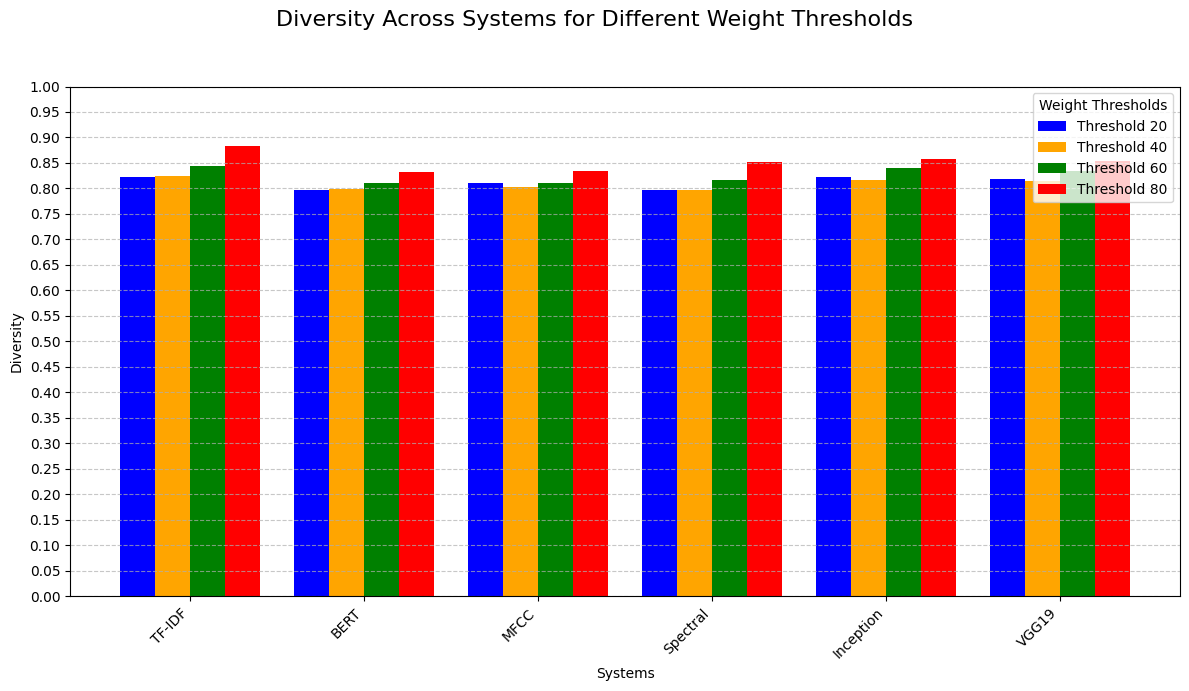

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

weight_thresholds = [ 20, 40, 60, 80]
systems = ['TF-IDF', 'BERT', 'MFCC', 'Spectral', 'Inception', 'VGG19']

# Convert to a DataFrame for easier plotting
diversity_df = pd.DataFrame(diversity_results)

# Define colors for thresholds
colors = ['blue', 'orange', 'green', 'red', 'brown']

# Set up bar width and positions
bar_width = 0.2
x = np.arange(len(systems))  # Positions for the systems

fig, ax = plt.subplots(figsize=(12, 7))
fig.suptitle("Diversity Across Systems for Different Weight Thresholds", fontsize=16)

# Plot bars for each threshold
for i, threshold in enumerate(weight_thresholds):
    ax.bar(
        x + i * bar_width,
        diversity_df[threshold],
        bar_width,
        label=f"Threshold {threshold}",
        color=colors[i % len(colors)]
    )

# Customize the plot
ax.set_xticks(x + bar_width * (len(weight_thresholds) - 1) / 2)
ax.set_xticklabels(systems, rotation=45, ha='right')
ax.set_ylabel("Diversity")
ax.set_xlabel("Systems")
ax.set_ylim(0, 1)  # Diversity scale range from 0 to 1
ax.set_yticks([i * 0.05 for i in range(21)])
ax.legend(title="Weight Thresholds")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import pandas as pd
from scripts.evaluation_metrics import (
    beyond_accuracy_metrics,
    run_evaluations,
)
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_tradeoffs_d(
    query_indices,
    datasets,
    systems,
    beyond_metrics,
    beyond_tags_column,
    beyond_popularity_column,
    weight_thresholds,
    N=10,
):
    """
    Evaluate trade-offs between NDCG and Diversity for multiple IR systems.

    Args
    ----
        query_indices
            List of indices for query songs in the datasets.
        datasets
            Dictionary mapping system names to their respective datasets.
        systems
            Dictionary mapping system names to their feature columns.
        beyond_metrics
            List of similarity metrics to evaluate (e.g., ['cosine', 'euclidean']).
        beyond_tags_column
            Name of the column containing tags for diversity.
        beyond_popularity_column
            Name of the column containing popularity scores.
        weight_thresholds
            List of thresholds for tag weights to calculate diversity.
        N
            Number of top results to evaluate.

    Returns
    -------
        pandas.DataFrame
            Trade-off results showing NDCG and Diversity for each system and threshold.
    """
    results = []

    for system_name, feature_columns in systems.items():
        print(f"Evaluating {system_name}:")
        dataset = datasets[system_name]

        for threshold in weight_thresholds:
            for metric in beyond_metrics:
                # Evaluate NDCG
                ndcg_scores = run_evaluations(
                    query_indices, dataset, feature_columns, [metric], N=N
                )
                ndcg = ndcg_scores[metric][f"NDCG@N"]

                # Evaluate Beyond-Accuracy Metrics
                beyond_scores = beyond_accuracy_metrics(
                    query_indices,
                    dataset,
                    feature_columns,
                    [metric],
                    tags_column=beyond_tags_column,
                    popularity_column=beyond_popularity_column,
                    N=N,
                    weight_threshold=threshold,
                )

                # Extract Diversity
                diversity = beyond_scores[metric][f"Div@N"]

                # Append results
                results.append(
                    {
                        "System": system_name,
                        "Metric": metric,
                        "Threshold": threshold,
                        f"NDCG@N": ndcg,
                        f"Div@N": diversity,
                    }
                )
        print()

    # Convert results to a DataFrame
    return pd.DataFrame(results)

# Parameters
N_tradeoff = 10
weight_thresholds = [0, 20, 40, 60, 80]
num_samples = 100
random.seed(42)
query_indices = random.sample(range(len(dataset)), num_samples)  # Replace with desired query indices

# Define datasets and feature columns for each system
systems = {
    'TF-IDF': tfidf_columns,
    'BERT': bert_columns,
    'MFCC': mfcc_columns,
    'Spectral': spectral_contrast_columns,
    'Inception': inception_columns,
    'VGG19': vgg19_columns
}
datasets = {
    'TF-IDF': merged_tfidf_dataset,
    'BERT': merged_bert_dataset,
    'MFCC': merged_audio_dataset,
    'Spectral': merged_audio_dataset,
    'Inception': merged_visual_dataset_incp,
    'VGG19': merged_visual_dataset_vgg19
}

beyond_metrics = ['cosine', 'euclidean']

# Evaluate trade-offs
tradeoff_results = evaluate_tradeoffs_d(
    query_indices,
    datasets,
    systems,
    beyond_metrics,
    beyond_tags_column='(tag, weight)',
    beyond_popularity_column='popularity',
    weight_thresholds=weight_thresholds,
    N=N_tradeoff
)



Evaluating TF-IDF:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:03<00:00, 27.84it/s]



Evaluating BERT:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:02<00:00, 33.43it/s]



Evaluating MFCC:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:02<00:00, 34.43it/s]



Evaluating Spectral:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:03<00:00, 30.10it/s]



Evaluating Inception:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]



Evaluating VGG19:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]

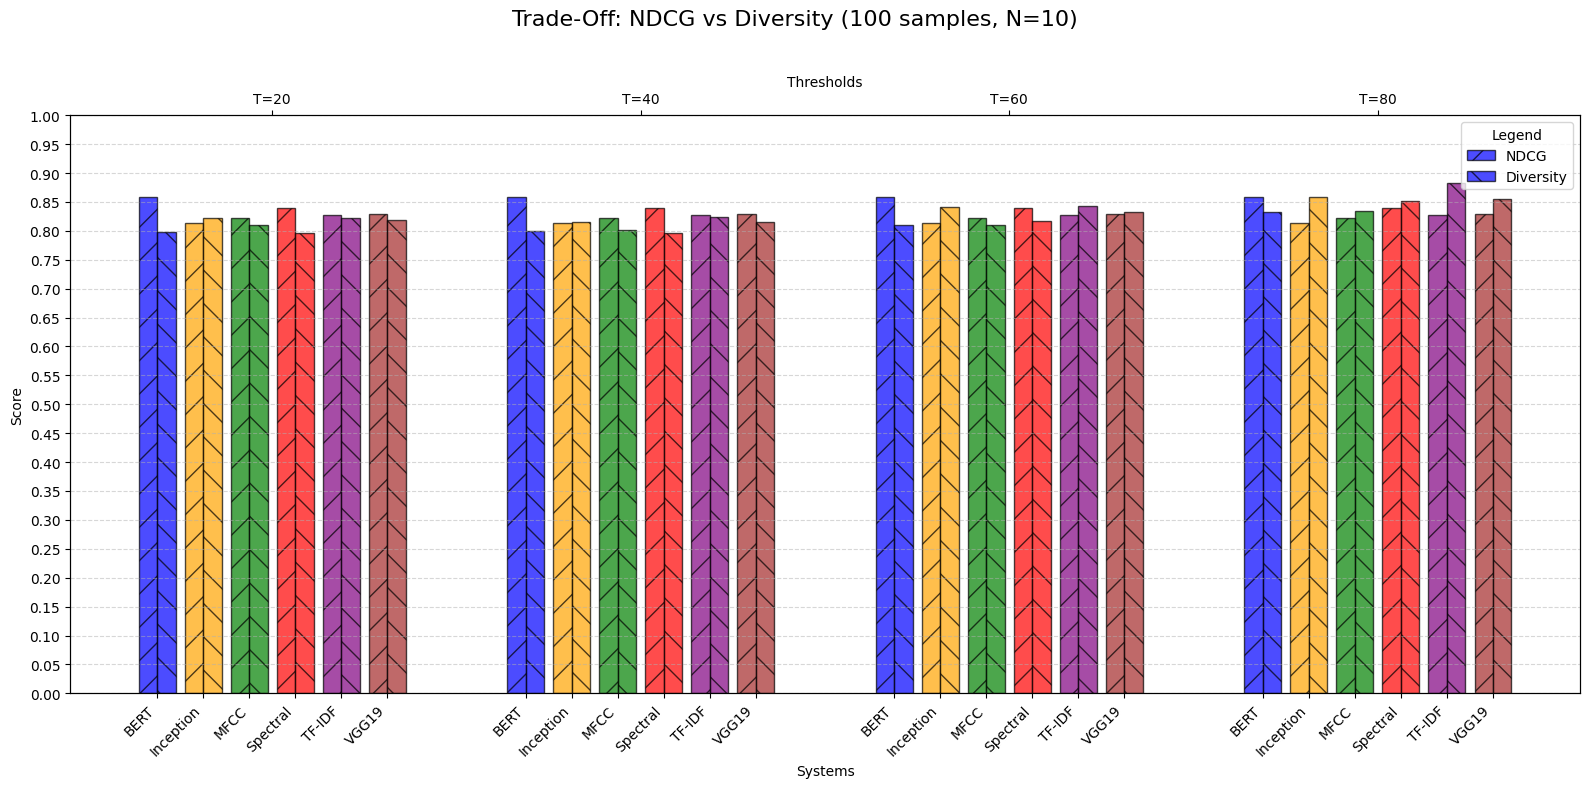

In [65]:
# Aggregate tradeoff results by averaging numeric metrics over multiple similarity metrics
numeric_columns = ["NDCG@N", "Div@N"]
aggregated_results = tradeoff_results.groupby(["System", "Threshold"])[numeric_columns].mean().reset_index()

# Define colors for systems
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Set up bar width and positions
thresholds = aggregated_results["Threshold"].unique()
systems = aggregated_results["System"].unique()
bar_width = 0.4
x_positions = []

# Gap between thresholds
threshold_gap = 2

# Create the figure
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Trade-Off: NDCG vs Diversity (100 samples, N=10)', fontsize=16)

hatch_patterns = ['/', '\\']  # Hatch patterns for NDCG and Diversity

# Plot data
current_x = 0
for threshold in thresholds:
    group = aggregated_results[aggregated_results["Threshold"] == threshold]
    ndcg_values = group["NDCG@N"]
    div_values = group["Div@N"]
    x = np.arange(current_x, current_x + len(systems))  # No space between systems
    x_positions.extend(x)
    
    # Plot NDCG bars with borders
    ax.bar(
        x - bar_width / 2, 
        ndcg_values, 
        width=bar_width, 
        color=colors, 
        edgecolor='black',  # Add border
        linewidth=1,        # Border thickness
        label="NDCG" if threshold == thresholds[0] else None, 
        alpha=0.7, 
        hatch=hatch_patterns[0]
    )
    
    # Plot Diversity bars with borders
    ax.bar(
        x + bar_width / 2, 
        div_values, 
        width=bar_width, 
        color=colors, 
        edgecolor='black',  # Add border
        linewidth=1,        # Border thickness
        label="Diversity" if threshold == thresholds[0] else None, 
        alpha=0.7, 
        hatch=hatch_patterns[1]
    )
    
    current_x += len(systems) + threshold_gap  # Add gap between thresholds

# Customize the plot
system_labels = [f"{system}" for _ in thresholds for system in systems]
threshold_labels = [f"T={threshold}" for threshold in thresholds for _ in systems]
ax.set_xticks(x_positions)
ax.set_xticklabels(system_labels, rotation=45, ha='right')
ax.set_xlabel("Systems")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_yticks([i * 0.05 for i in range(21)])
ax.legend(loc='upper right', title="Legend")
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add a secondary x-axis for thresholds
threshold_midpoints = [(i + (i + len(systems) - 1)) / 2 for i in range(0, current_x, len(systems) + threshold_gap)]
ax2 = ax.twiny()
ax2.set_xticks(threshold_midpoints)
ax2.set_xticklabels([f"T={threshold}" for threshold in thresholds])
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel("Thresholds")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Trade-off Between NDCG and Beyond-Accuracy

In [17]:
N_tradeoff = 10
num_samples = 100
random.seed(42)
query_indices = random.sample(range(len(dataset)), num_samples)  # Replace with desired query indices

In [67]:
# Define datasets and feature columns for each system
systems = {
    'Random': None,
    'TF-IDF': tfidf_columns,
    'BERT': bert_columns,
    'MFCC': mfcc_columns,
    'Spectral': spectral_contrast_columns,
    'Inception': inception_columns,
    'VGG19': vgg19_columns
}
datasets = {
    'Random': dataset,
    'TF-IDF': merged_tfidf_dataset,
    'BERT': merged_bert_dataset,
    'MFCC': merged_audio_dataset,
    'Spectral': merged_audio_dataset,
    'Inception': merged_visual_dataset_incp,
    'VGG19': merged_visual_dataset_vgg19
}

beyond_metrics = ['cosine', 'euclidean']
tradeoff_results_ = evaluate_tradeoffs(
    query_indices,
    datasets,
    systems,
    beyond_metrics,
    beyond_tags_column='(tag, weight)',
    beyond_popularity_column='popularity',
    N=N_tradeoff
)

Random:


Processing queries for Random Baseline: 100%|██████████| 100/100 [00:00<00:00, 437.64it/s]



TF-IDF:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:04<00:00, 22.01it/s]



BERT:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]



MFCC:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:03<00:00, 32.80it/s]



Spectral:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:04<00:00, 22.72it/s]



Inception:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]



VGG19:


Processing queries for euclidean metric: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Trade-Off Results:
       System     Metric    NDCG@N     Div@N  AvgPop@N
0      Random     random  0.753719  0.883864  0.387193
1      TF-IDF     cosine  0.828255  0.847101  0.413091
2      TF-IDF  euclidean  0.828401  0.840206  0.408614
3        BERT     cosine  0.858659  0.803538  0.426068
4        BERT  euclidean  0.857092  0.818385  0.429580
5        MFCC     cosine  0.810331  0.819266  0.409420
6        MFCC  euclidean  0.834666  0.800442  0.415409
7    Spectral     cosine  0.839122  0.827441  0.405648
8    Spectral  euclidean  0.839548  0.807535  0.404125
9   Inception     cosine  0.820120  0.842333  0.407989
10  Inception  euclidean  0.806544  0.838778  0.402455
11      VGG19     cosine  0.836011  0.826398  0.402693
12      VGG19  euclidean  0.821295  0.840515  0.409080


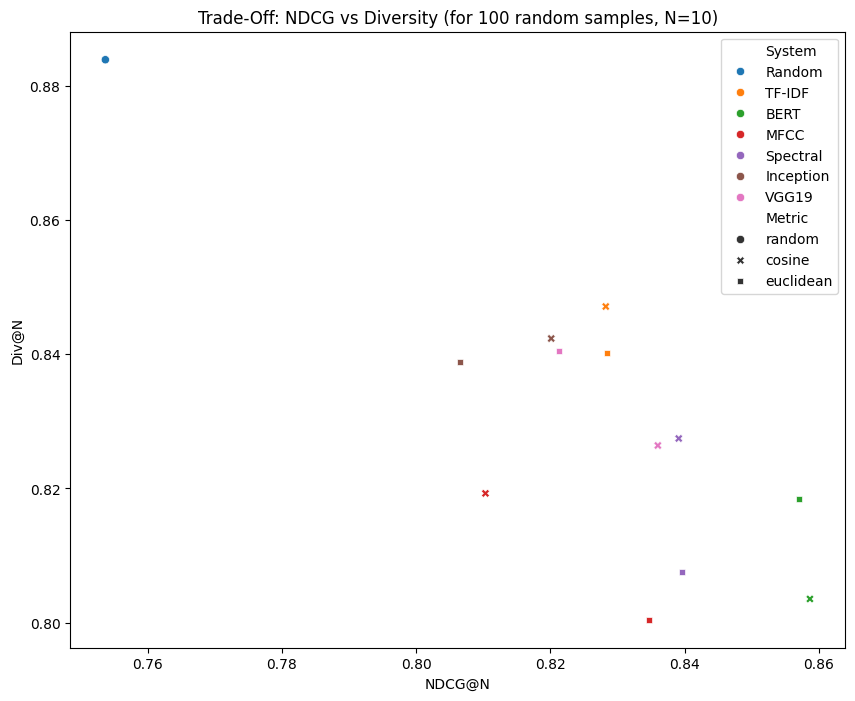

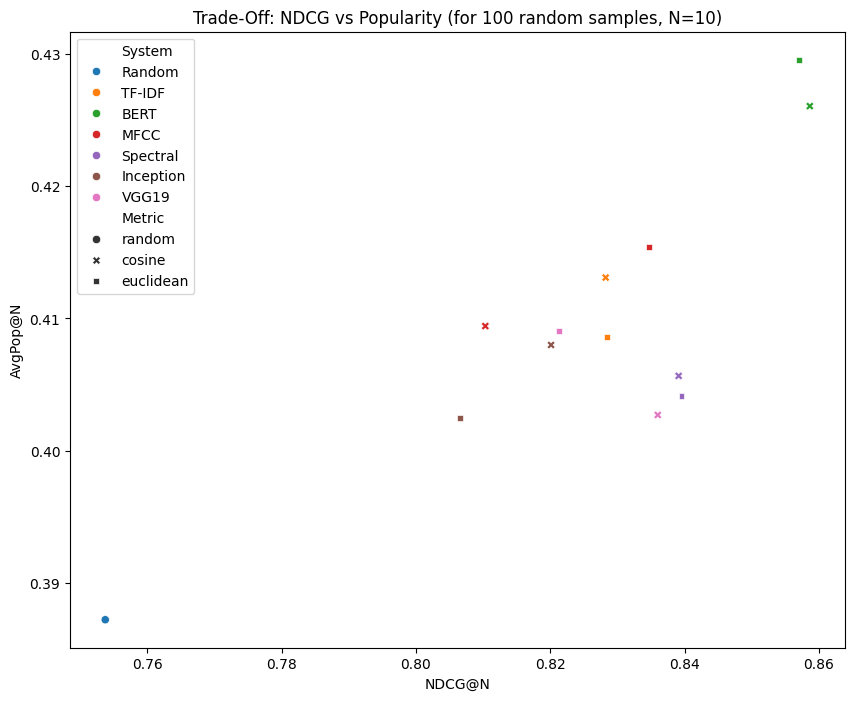

In [68]:
print("\nTrade-Off Results:")
print(tradeoff_results_)

# Optionally, plot the trade-offs
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

# Plot NDCG vs Diversity
sns.scatterplot(data=tradeoff_results_, x=f'NDCG@N', y=f'Div@N', hue='System', style='Metric')
plt.title(f'Trade-Off: NDCG vs Diversity (for {num_samples} random samples, N={N_tradeoff})')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
# Plot NDCG vs Popularity
sns.scatterplot(data=tradeoff_results_, x=f'NDCG@N', y=f'AvgPop@N', hue='System', style='Metric')
plt.title(f'Trade-Off: NDCG vs Popularity (for {num_samples} random samples, N={N_tradeoff})')
plt.show()

## Precompute recommendations

In [79]:
# def evaluate_precomputed_embeddings_retrieval(feature_space: str, dataset, feature_columns, similarity_metric: str="cosine", N=10):
#     """
#     Evaluate the retrieval system using precomputed embeddings and save results as JSON.

#     Args
#     ----
#         feature_space
#             Name of the IR system, must be one of "TF-IDF", "BERT", "MFCC", "SpectralContrast", "InceptionNet", or "VGG19".
#         dataset
#             Full dataset containing genres and precomputed embedding vectors.
#         feature_columns
#             List of columns corresponding to embedding features for the chosen system.
#         similarity_metric
#             Similarity metric to use (e.g., 'cosine', 'euclidean').
#         N
#             Number of top results to retrieve for evaluation.
    
#     Returns
#     -------
#         dict
#             A dictionary containing the evaluation metrics (Precision@N, Recall@N, NDCG@N, MRR).
#     """

#     available_systems = ["Random", "TF-IDF", "BERT", "MFCC", "Spectral", "Inception", "VGG19"]
#     if feature_space not in available_systems:
#         raise ValueError(f"feature_space must be one of {', '.join(f'\"{system}\"' for system in available_systems)}")

#     os.makedirs("public", exist_ok=True)

#     hash_input = feature_space + str(len(dataset)) + str(feature_columns) + str(similarity_metric) + str(N)
#     params_hash = hashlib.md5(hash_input.encode()).hexdigest()
#     filename = f"{params_hash[:5]}.json"
#     filepath = os.path.join("public/data/precomputed_systems", filename)

#     if os.path.exists(filepath):
#         with open(filepath, 'r') as f:
#             cached_data = json.load(f)
#         metadata = cached_data.get("metadata", {})
#         return {
#             "Precision@N": metadata.get("Precision@N", 0),
#             "Recall@N": metadata.get("Recall@N", 0),
#             "NDCG@N": metadata.get("NDCG@N", 0),
#             "MRR": metadata.get("MRR", 0),
#         }

#     precision_list, recall_list, ndcg_list, mrr_list = [], [], [], []
#     recommendations_dict = {}

#     for idx, query_song in tqdm(dataset.iterrows(), total=len(dataset), desc=f"Evaluating {feature_space} ({similarity_metric})"):
#         query_tags = query_song['(tag, weight)']
#         relevant_songs = []
#         relevance_scores = {}

#         for _, candidate_song in dataset.iterrows():
#             candidate_tags = candidate_song['(tag, weight)']
#             relevance_score = compute_weighted_jaccard(query_tags, candidate_tags)
#             if relevance_score > 0:
#                 relevant_songs.append(candidate_song['id'])
#                 relevance_scores[candidate_song['id']] = relevance_score

#         # merged_dataset = pd.read_csv('public/data/merged_dataset.tsv', sep='\t')
#         # merged_dataset = merged_dataset.merge(pd.DataFrame(list(relevance_scores.items()), columns=['id', 'relevance_score']), on='id', how='left')
#         # merged_dataset.to_csv('public/data/temp/dataset_with_precomp_relevance.tsv', sep='\t', index=False)
        
#         if feature_columns is None:
#             retrieved_songs = random_baseline(query_song, dataset, N)['id'].tolist()
#         else:
#             retrieved_songs = retrieve_n_songs_by_similarity(query_song, dataset, feature_columns, metric=similarity_metric, N=N)['id'].tolist()
#             print(retrieved_songs)

#         recommendations_dict[query_song['id']] = retrieved_songs

#         precision_list.append(precision_at_k(retrieved_songs, relevant_songs, k=N))
#         recall_list.append(recall_at_k(retrieved_songs, relevant_songs, k=N))
#         ndcg_list.append(ndcg_at_k(retrieved_songs, relevant_songs, k=N))
#         mrr_list.append(mean_reciprocal_rank(retrieved_songs, relevant_songs))
        

#     metrics = {
#         "Precision@N": sum(precision_list) / len(precision_list),
#         "Recall@N": sum(recall_list) / len(recall_list),
#         "NDCG@N": sum(ndcg_list) / len(ndcg_list),
#         "MRR": sum(mrr_list) / len(mrr_list),
#     }

#     output_data = {
#         "metadata": {
#             "feature_space": feature_space,
#             "N": N,
#             "similarity_metric": similarity_metric,
#             "Precision@N": metrics["Precision@N"],
#             "Recall@N": metrics["Recall@N"],
#             "NDCG@N": metrics["NDCG@N"],
#             "MRR": metrics["MRR"]
#         },
#         "content": recommendations_dict
#     }

#     with open(filepath, 'w') as f:
#         json.dump(output_data, f, indent=4)

#     return metrics

In [25]:
import torch
from sklearn.preprocessing import normalize
import pandas as pd
from tqdm import tqdm

def evaluate_precomputed_embeddings_retrieval(feature_space: str, dataset, feature_columns, similarity_metric: str = "cosine", N=10):
    """
    Evaluate the retrieval system using precomputed embeddings and save results as JSON.

    Args
    ----
        feature_space: Name of the feature space(e.g., "TF-IDF", "BERT", etc.).
        dataset: Full dataset containing features for similarity computation.
        feature_columns: List of columns corresponding to feature embeddings.
        similarity_metric: Similarity metric to use (e.g., 'cosine', 'euclidean').
        N: Number of top results to retrieve for evaluation.

    Returns
    -------
        dict: A dictionary containing evaluation metrics (Precision@10, Recall@10, NDCG@10, MRR).
    """
    available_systems = ["Random", "TF-IDF", "BERT", "MFCC", "Spectral", "Inception", "VGG19"]
    if feature_space not in available_systems:
        raise ValueError(f"feature_space must be one of {', '.join(f'\"{system}\"' for system in available_systems)}")

    # Ensure the public directory exists
    os.makedirs("public", exist_ok=True)

    # Create a hash based on input parameters
    hash_input = feature_space + str(len(dataset)) + str(feature_columns) + str(similarity_metric) + str(N)
    params_hash = hashlib.md5(hash_input.encode()).hexdigest()
    filename = f"{params_hash[:5]}.json"
    filepath = os.path.join("public/data/precomputed_systems", filename)

    # Check if the JSON cache file exists
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            cached_data = json.load(f)
        # Extract metrics from cached file if present
        metadata = cached_data.get("metadata", {})
        print(f"The results are already cached. Metadata: {metadata}")
        return {
            "Precision@N": metadata.get("Precision@N", 0),
            "Recall@N": metadata.get("Recall@N", 0),
            "NDCG@N": metadata.get("NDCG@N", 0),
            "MRR": metadata.get("MRR", 0),
        }

    # Move features to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    feature_matrix = torch.tensor(dataset[feature_columns].values, dtype=torch.float32, device=device)
    feature_matrix = torch.nn.functional.normalize(feature_matrix)  # Normalize features for cosine similarity

    precision_list, recall_list, ndcg_list, mrr_list = [], [], [], []
    recommendations_dict = {}

    for _, query_song in tqdm(dataset.iterrows(), total=len(dataset), desc=f"Evaluating {feature_space} ({similarity_metric})"):
        query_vector = torch.tensor(
            query_song[feature_columns].astype(float).values,  # Ensure float type
            dtype=torch.float32,
            device=device
        ).unsqueeze(0)

        # Compute similarity in bulk
        if similarity_metric == 'cosine':
            similarities = torch.mm(query_vector, feature_matrix.T).squeeze().cpu().numpy()
        elif similarity_metric == 'euclidean':
            distances = torch.cdist(query_vector, feature_matrix).squeeze().cpu().numpy()
            similarities = 1 / (1 + distances)  # Convert distances to similarity
        else:
            raise ValueError("Unsupported metric. Use 'cosine' or 'euclidean'.")

        # Add similarity scores to dataset and exclude the query song
        dataset['similarity'] = similarities
        retrieved_songs = dataset[dataset['id'] != query_song['id']].sort_values(by='similarity', ascending=False).head(N)['id'].tolist()

        # Define relevance using Weighted Jaccard
        query_tags = query_song['(tag, weight)']
        relevant_songs = []
        for _, candidate_song in dataset.iterrows():
            candidate_tags = candidate_song['(tag, weight)']
            relevance_score = compute_weighted_jaccard(query_tags, candidate_tags)
            if relevance_score > 0:  # Only consider non-zero similarities
                relevant_songs.append(candidate_song['id'])
        
        # tag_weight_dicts = dataset['(tag, weight)'].apply(pd.Series)
        # # Convert the query tags to a Series for vectorized operations
        # query_tags_series = pd.Series(query_tags)
        # # Compute Weighted Jaccard Similarity in bulk
        # intersection = tag_weight_dicts.apply(lambda row: sum(min(query_tags_series.get(tag, 0), row.get(tag, 0)) for tag in query_tags_series.index & row.index), axis=1)
        # union = tag_weight_dicts.apply(lambda row: sum(max(query_tags_series.get(tag, 0), row.get(tag, 0)) for tag in query_tags_series.index | row.index), axis=1)
        # similarity_scores = intersection / union
        # # Filter out songs with zero similarity and retrieve their IDs
        # relevant_songs = dataset.loc[similarity_scores > 0, 'id'].tolist()

        # Store recommendations
        recommendations_dict[query_song['id']] = retrieved_songs

        # Compute metrics
        precision_list.append(precision_at_k(retrieved_songs, relevant_songs, k=N))
        recall_list.append(recall_at_k(retrieved_songs, relevant_songs, k=N))
        ndcg_list.append(ndcg_at_k(retrieved_songs, relevant_songs, k=N))
        mrr_list.append(mean_reciprocal_rank(retrieved_songs, relevant_songs))

    # Compute averages
    metrics = {
        "Precision@N": sum(precision_list) / len(precision_list),
        "Recall@N": sum(recall_list) / len(recall_list),
        "NDCG@N": sum(ndcg_list) / len(ndcg_list),
        "MRR": sum(mrr_list) / len(mrr_list),
    }

    # Save recommendations and metrics to JSON file
    output_data = {
        "metadata": {
            "feature_space": feature_space,
            "N": N,
            "similarity_metric": similarity_metric,
            "Precision@N": metrics["Precision@N"],
            "Recall@N": metrics["Recall@N"],
            "NDCG@N": metrics["NDCG@N"],
            "MRR": metrics["MRR"]
        },
        "content": recommendations_dict
    }

    with open(filepath, 'w') as f:
        json.dump(output_data, f, indent=4)

    return metrics

## Saving results for each system

In [26]:
N = 100

In [ ]:
random_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="Random",
    dataset=dataset,
    feature_columns=None,
    similarity_metric='random',
    N=N
)
print("Random Metrics:", random_metrics)

In [27]:
# merged_tfidf_dataset_cropped = merged_tfidf_dataset.head(1000).copy()

# Cosine
tfidf_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="TF-IDF",
    dataset=merged_tfidf_dataset,
    feature_columns=tfidf_columns,
    similarity_metric='cosine',
    N=N
)
print("TF-IDF (Cosine) Metrics:", tfidf_metrics)

# Euclidean
tfidf_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="TF-IDF",
    dataset=merged_tfidf_dataset,
    feature_columns=tfidf_columns,
    similarity_metric='euclidean',
    N=N
)
print("TF-IDF (Euclidean) Metrics:", tfidf_metrics)

cuda


Evaluating TF-IDF (cosine):   0%|          | 16/5148 [00:07<37:25,  2.29it/s]


KeyboardInterrupt: 

In [ ]:
bert_cosine_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="BERT",
    dataset=merged_bert_dataset,
    feature_columns=bert_columns,
    similarity_metric='cosine',
    N=N
)
print("BERT (Cosine) Metrics:", bert_cosine_metrics)

bert_euclidean_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="BERT",
    dataset=merged_bert_dataset,
    feature_columns=bert_columns,
    similarity_metric='euclidean',
    N=N
)
print("BERT (Euclidean) Metrics:", bert_euclidean_metrics)

In [ ]:
mfcc_cosine_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="MFCC",
    dataset=merged_audio_dataset,
    feature_columns=mfcc_columns,
    similarity_metric='cosine',
    N=N
)
print("MFCC (Cosine) Metrics:", mfcc_cosine_metrics)

mfcc_euclidean_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="MFCC",
    dataset=merged_audio_dataset,
    feature_columns=mfcc_columns,
    similarity_metric='euclidean',
    N=N
)
print("MFCC (Euclidean) Metrics:", mfcc_euclidean_metrics)

In [ ]:
spectral_cosine_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="Spectral",
    dataset=merged_audio_dataset,
    feature_columns=spectral_contrast_columns,
    similarity_metric='cosine',
    N=N
)
print("Spectral (Cosine) Metrics:", spectral_cosine_metrics)

spectral_euclidean_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="Spectral",
    dataset=merged_audio_dataset,
    feature_columns=spectral_contrast_columns,
    similarity_metric='euclidean',
    N=N
)
print("Spectral (Euclidean) Metrics:", spectral_euclidean_metrics)

In [ ]:
inception_cosine_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="Inception",
    dataset=merged_visual_dataset_incp,
    feature_columns=inception_columns,
    similarity_metric='cosine',
    N=N
)
print("InceptionNet (Cosine) Metrics:", inception_cosine_metrics)

inception_euclidean_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="Inception",
    dataset=merged_visual_dataset_incp,
    feature_columns=inception_columns,
    similarity_metric='euclidean',
    N=N
)
print("InceptionNet (Euclidean) Metrics:", inception_euclidean_metrics)

In [ ]:
vgg19_cosine_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="VGG19",
    dataset=merged_visual_dataset_vgg19,
    feature_columns=vgg19_columns,
    similarity_metric='cosine',
    N=N
)
print("VGG19 (Cosine) Metrics:", vgg19_cosine_metrics)

vgg19_euclidean_metrics = evaluate_precomputed_embeddings_retrieval(
    feature_space="VGG19",
    dataset=merged_visual_dataset_vgg19,
    feature_columns=vgg19_columns,
    similarity_metric='euclidean',
    N=N
)
print("VGG19 (Euclidean) Metrics:", vgg19_euclidean_metrics)

In [11]:
import os
import json
import hashlib

In [12]:
def update_beyond_accuracy_in_metadata(feature_space, dataset, feature_columns, similarity_metric, N, tags_column, popularity_column):
    """
    Update JSON files with beyond-accuracy metrics (Div@N and AvgPop@N).

    Args:
        feature_space (str): Name of the IR system (e.g., "TF-IDF", "BERT", "Random").
        dataset (pd.DataFrame): Full dataset containing songs and their metadata.
        feature_columns (list or None): List of feature column names for the embeddings, or None for "Random".
        similarity_metric (str): Similarity metric used (e.g., 'cosine', 'euclidean').
        N (int): Number of top results used.
        tags_column (str): Column containing tags for diversity computation.
        popularity_column (str): Column containing popularity values.

    Returns:
        None
    """
    # Calculate hash for the file name
    hash_input = feature_space + str(len(dataset)) + str(feature_columns) + str(similarity_metric) + str(N)
    params_hash = hashlib.md5(hash_input.encode()).hexdigest()
    filename = f"{params_hash[:5]}.json"
    filepath = os.path.join("public/data/precomputed_systems", filename)
    
    if not os.path.exists(filepath):
        print(f"File {filename} not found.")
        return

    # Load the JSON file
    with open(filepath, 'r') as f:
        data = json.load(f)
        # Extract metrics from cached file if present
        metadata = data.get("metadata", {})
        if "Div@N" in metadata and "AvgPop@N" in metadata:
            print("Beyond-accuracy metrics (Div@N and AvgPop@N) are already present in the metadata.\n")
            return {
                "Precision@N": metadata.get("Precision@N", 0),
                "Recall@N": metadata.get("Recall@N", 0),
                "NDCG@N": metadata.get("NDCG@N", 0),
                "MRR": metadata.get("MRR", 0),
                "Div@N": metadata.get("Div@N", 0),
                "AvgPop@N": metadata.get("AvgPop@N", 0),
            }

    # Randomly sample query indices
    query_indices = dataset.sample(n=100, random_state=42).index.tolist()

    if feature_columns is None:
        beyond_metrics = beyond_accuracy_metrics(
            query_indices=query_indices,
            dataset=dataset,
            feature_columns=feature_columns,
            metrics='random',
            tags_column=tags_column,
            popularity_column=popularity_column,
            N=N
        )
        print(beyond_metrics)
        # Update metadata with Div@N and AvgPop@N
        if "metadata" not in data:
            data["metadata"] = {}
        data["metadata"]["Div@N"] = beyond_metrics['random']["Div@N"]
        data["metadata"]["AvgPop@N"] = beyond_metrics['random']["AvgPop@N"]
    else:
        # Compute beyond-accuracy metrics
        beyond_metrics = beyond_accuracy_metrics(
            query_indices=query_indices,
            dataset=dataset,
            feature_columns=feature_columns,
            metrics=[similarity_metric],
            tags_column=tags_column,
            popularity_column=popularity_column,
            N=N
        )

        # Update metadata with Div@N and AvgPop@N
        if "metadata" not in data:
            data["metadata"] = {}
        data["metadata"]["Div@N"] = beyond_metrics[similarity_metric]["Div@N"]
        data["metadata"]["AvgPop@N"] = beyond_metrics[similarity_metric]["AvgPop@N"]

    # Save the updated JSON file
    with open(filepath, 'w') as f:
        json.dump(data, f, indent=4)
    print(f"Updated {filename} with Div@N and AvgPop@N.\n")


In [13]:
N = 100

In [ ]:
update_beyond_accuracy_in_metadata(
    feature_space="Random",
    dataset=dataset,
    feature_columns=None,
    similarity_metric='random',
    N=N,
    tags_column='(tag, weight)',
    popularity_column='popularity'
)

In [ ]:
# Define datasets, feature columns, and metrics for each IR system
datasets = {
    "TF-IDF": merged_tfidf_dataset,
    "BERT": merged_bert_dataset,
    "MFCC": merged_audio_dataset,
    "Spectral": merged_audio_dataset,
    "Inception": merged_visual_dataset_incp,
    "VGG19": merged_visual_dataset_vgg19
}

feature_columns = {
    "TF-IDF": tfidf_columns,
    "BERT": bert_columns,
    "MFCC": mfcc_columns,
    "Spectral": spectral_contrast_columns,
    "Inception": inception_columns,
    "VGG19": vgg19_columns
}

similarity_metrics = ["cosine", "euclidean"]
available_systems = ["TF-IDF", "BERT", "MFCC", "Spectral", "Inception", "VGG19"]

# Loop through all systems, datasets, feature columns, and metrics
for system in available_systems:
    for metric in similarity_metrics:
        print(f"Processing {system} with {metric} and N={N}...")
        update_beyond_accuracy_in_metadata(
            feature_space=system,
            dataset=datasets[system],
            feature_columns=feature_columns[system],
            similarity_metric=metric,
            N=N,
            tags_column='(tag, weight)',
            popularity_column='popularity'
        )